# Setup

In [1]:
import sys
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt

In [2]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [3]:
# A helper function to turn numeric latitudes to into strings
def format_lat(lat):
    return str(-1 * lat) + 'S' if lat < 0 else str(lat) + 'N'

In [4]:
# A helper function to subset 30S, since now the surface vars exist for all longitudes - values taken from basin function!
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

In [5]:
# A helper function to add lags to the input dataset
def add_lags_inputs(inputs, num_months_lag):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        for i in range(1, num_months_lag + 1):
            inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [6]:
# A helper function to build filenames given the experiment variables
def build_filename(remove_trend, remove_season, num_months_lag, no_zonal_avgs, var_subset):
    filename = ''
    
    if num_months_lag > 0:
        filename += f'{num_months_lag}month_time_lag_'
    else:
        filename += 'full_static_'

    if no_zonal_avgs:
        filename += 'full_zonal_'
    else:
        filename += 'zonal_avgs_'

    if remove_trend:
        filename += 'detrend_'
    else:
        filename += 'trend_'

    if remove_trend:
        filename += 'deseason'
    else:
        filename += 'season'

    if var_subset is not None:
        filename += '_' + '+'.join(var_subset)

    return filename

# Experiment variables

In [7]:
# CONSTANTS
data_home = '/Users/emiliolr/Google Drive/My Drive/GTC'
lats = [26, -30, -55, -60]

# CHANGE BASED ON EXPERIMENT
base_path = '/Users/emiliolr/Desktop/regression_results'

remove_season = False
remove_trend = False

num_months_lag = 0

no_zonal_avgs = True
var_subset = ['ZWS']

filename = build_filename(remove_trend, remove_season, num_months_lag, no_zonal_avgs, var_subset)
print(filename)

# MISCELLANEOUS
verbose = True
mape_thresh = 0.5
cross_val_folds = 4
param_grid_levels = 4

full_static_full_zonal_trend_season_ZWS


# Running linear regression experiments

In [65]:
# Looping through each latitude, prepping data, hyperparam tuning, and saving the results
for lat in lats:
    lat_str = format_lat(lat)
    filename_lat = f'{lat_str}_{filename}'
    print(f'Training on {lat_str}...')
    
    # Load in predictor vars
    inputs = xr.open_dataset(f'{data_home}/ecco_data_minimal/{lat_str}.nc')

    #  fixing longitude bounds of 30S
    if lat == -30:
        inputs = mask_30S(inputs)
    
    inputs = inputs.isel(latitude = 1) # pull out just the lat of interest
    inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better

    #  fixing interior null values for 55S
    if lat == -55:
        inputs = inputs.dropna('longitude', how = 'all')

    if var_subset is not None:
        inputs = inputs[var_subset]

    # Load in response var
    outputs_fp = f'{data_home}/ecco_data_minimal/{lat_str}_moc_density.pickle'

    with open(outputs_fp, 'rb') as f:
        outputs = pickle.load(f)
    
    outputs = np.expand_dims(outputs, 1) 
    outputs = xr.Dataset(data_vars = {'moc' : (['time', 'latitude'], outputs)}, 
                         coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(lat)})

    # Preprocessing all inputs
    pp_data = apply_preprocessing(inputs,
                                  mode = 'inputs',
                                  remove_season = remove_season,
                                  remove_trend = remove_trend,
                                  standardize = True,
                                  lowpass = False)
    
    #  adding time lags for inputs 
    pp_data = add_lags_inputs(pp_data, num_months_lag)
    pp_data = pp_data.dropna('time', how = 'any') # removing timesteps at beginning w/no lags

    #  reshape inputs as desired and convert to a numpy array
    data_vars = list(pp_data.keys())
    if not no_zonal_avgs:
        pp_data_np = reshape_inputs(pp_data, keep_coords = ['time'], data_vars = data_vars)
    else:
        pp_data_np = pp_data.to_array().transpose('time', ...).squeeze().values 
        pp_data_np = pp_data_np.reshape(pp_data_np.shape[0], -1)

        print("axes: ['time', 'feature']")
        print(f'variables: {var_subset}')
        print(f'shape: {pp_data_np.shape}')
    
    #  MOC strength from data
    strength = apply_preprocessing(outputs,
                                   mode = 'outputs',
                                   remove_season = remove_season,
                                   remove_trend = remove_trend,
                                   standardize = False,
                                   lowpass = False)
    strength_np = strength.moc.squeeze().values
    strength_np = strength_np[num_months_lag : ] # truncate the timeseries to match the lagged inputs
    
    X = pp_data_np
    y = strength_np

    #  adding a intercept - ones in the first column
    X = sm.add_constant(X)

    #  train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, 
                                                        stratify = None, random_state = 123456)
    
    # Define the hyperparameters to optimize over
    param_grid = {
        'alpha' : np.logspace(-4, 4, param_grid_levels),
        'L1_wt' : np.linspace(0, 1, param_grid_levels)
    }
    
    # TRAINING: grid search with cross-validation
    grid_search = GridSearchCV(SMWrapper(), param_grid, cv = cross_val_folds, 
                               scoring = 'neg_mean_squared_error', verbose = verbose)
    grid_search.fit(X_train, y_train)
    
    #  report best result
    if verbose:
        print(f'Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}')
    
    #  calculate test performance and optionally report
    y_pred = grid_search.best_estimator_.predict(X_test)
    metric_dict = {}
    
    metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
    metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
    metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
    metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)

    #  calculating custom MAPE to ignore the smallest observed MOC values
    mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
    pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
    metric_dict['MAPE_thresh'] = f'{round(mape * 100, 3)} (thresh={mape_thresh}, {pct_kept}% kept)'

    if verbose:
        print(metric_dict)

    # Saving regression results to a text file for re-interpretation later
    txt_fp = f'{base_path}/{filename_lat}_RESULTS.txt'
    reg_results_txt(grid_search, txt_fp, data_vars, metric_dict, save_weights = not no_zonal_avgs)

    # Extracting all predictions in time order
    train_set_pred = grid_search.best_estimator_.predict(X_train)
    test_set_pred = grid_search.best_estimator_.predict(X_test)
    all_preds = np.concatenate([train_set_pred, test_set_pred])

    # Plotting results: timeseries
    time = pp_data.time.values
    fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
    
    plt_fp = f'{base_path}/{filename_lat}_TIMESERIES.png'
    plt.savefig(plt_fp, bbox_inches = 'tight')
    plt.close()

    # Plotting results: scatterplot
    fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
    
    plt_fp = f'{base_path}/{filename_lat}_SCATTER.png'
    plt.savefig(plt_fp, bbox_inches = 'tight')
    plt.close()

    print('------')

Training on 26N...
axes: ['time', 'feature']
variables: ['ZWS']
shape: (312, 164)
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best MSE (cross-validation): 4.527
{'R^2': 0.573, 'MSE': 1.886, 'RMSE': 1.373, 'MAE': 1.055, 'MAPE': 176.406, 'MAPE_thresh': '73.281 (thresh=0.5, 79.787% kept)'}
------
Training on 30S...
axes: ['time', 'feature']
variables: ['ZWS']
shape: (312, 440)
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best MSE (cross-validation): 7.212
{'R^2': 0.846, 'MSE': 7.977, 'RMSE': 2.824, 'MAE': 2.221, 'MAPE': 21.415, 'MAPE_thresh': '21.415 (thresh=0.5, 100.0% kept)'}
------
Training on 55S...
axes: ['time', 'feature']
variables: ['ZWS']
shape: (312, 706)
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best MSE (cross-validation): 16.376
{'R^2': 0.624, 'MSE': 12.193, 'RMSE': 3.492, 'MAE': 2.678, 'MAPE': 40.249, 'MAPE_thresh': '40.248 (thresh=0.5, 100.0% kept)'}
------
Training on 60S...
axes: ['time', 'feature']
variables: ['ZWS']
sh

# Validating best results
60S, full zonal, only OBP. Keep trend and season.

In [23]:
# Read in inputs
lat = '60S'
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat}.nc")

inputs = inputs.isel(latitude = 1) # pull out just 60S
inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better
inputs = inputs.transpose('time', 'latitude', 'longitude')
inputs

<xarray.Dataset>
Dimensions:    (latitude: 1, time: 312, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 -0.9153 -0.9153 ... -0.851
    ZWS        (time, latitude, longitude) float32 0.09556 0.09556 ... 0.1381
    OBP        (time, latitude, longitude) float32 35.04 35.04 ... 37.31 37.31
    SSS        (time, latitude, longitude) float32 33.87 33.87 ... 33.92 33.92
    SST        (time, latitude, longitude) float32 5.382 5.382 ... 3.76 3.76

In [24]:
# Read in MOC timeseries
outputs_fp = f"{data_home}/ecco_data_minimal/{lat}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f)

outputs = np.expand_dims(outputs, 1) # grabbing just 60S
outputs = xr.Dataset(data_vars = {'moc' : (['time', 'latitude'], outputs)}, 
                     coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60)})
outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int64 -60
Data variables:
    moc       (time, latitude) float64 -13.38 -14.45 -6.522 ... 2.564 -15.85

In [30]:
# Apply standardization, not using preprocessing function
from sklearn.preprocessing import StandardScaler

obp = inputs.OBP.squeeze().values
moc_strength = outputs.moc.squeeze().values
X, y = obp, moc_strength

# Train/test split - manually or sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, stratify = None)
# X_train, X_test = X[ : int(0.7 * len(X))], X[int(0.7 * len(X)) : ]
# y_train, y_test = y[ : int(0.7 * len(X))], y[int(0.7 * len(X)) : ]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test = sm.add_constant(X_train), sm.add_constant(X_test)
print(X_train.shape, X_test.shape)

(218, 721) (94, 721)


In [31]:
from sklearn.linear_model import ElasticNet

# Best hyperparams from grid search
L1_wt = 1.0
alpha = 0.046415888336127774

# Fit ElasticNet to the data
sm_model = sm.OLS(y_train, X_train).fit_regularized(alpha = alpha, L1_wt = L1_wt)

# Trying sklearn ElasticNet implementation
sklearn_model = ElasticNet(alpha = alpha, l1_ratio = L1_wt, fit_intercept = False)
sklearn_model.fit(X_train, y_train);

In [33]:
# Evaluate on the test set
model = sklearn_model
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R2:', r2)

RMSE: 1.5338980185743514
MAE: 1.1785788600085478
MAPE: 0.3554355218401937
R2: 0.9556915813219944


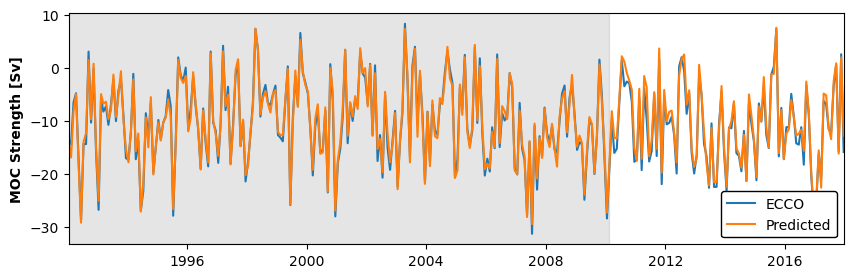

In [34]:
# Plotting for sanity check
all_preds = model.predict(np.concatenate((X_train, X_test), axis = 0))
time = outputs.time.values

timeseries_comparison(all_preds, y, time, len(X_train));

# Source code for experiment loop

In [16]:
lat = '60S'
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat}.nc")

# inputs = mask_30S(inputs)

inputs = inputs.isel(latitude = 1) # pull out just 60S
inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better
inputs = inputs.transpose('time', 'latitude', 'longitude')
inputs

<xarray.Dataset>
Dimensions:    (latitude: 1, time: 312, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 -0.9153 -0.9153 ... -0.851
    ZWS        (time, latitude, longitude) float32 0.09556 0.09556 ... 0.1381
    OBP        (time, latitude, longitude) float32 35.04 35.04 ... 37.31 37.31
    SSS        (time, latitude, longitude) float32 33.87 33.87 ... 33.92 33.92
    SST        (time, latitude, longitude) float32 5.382 5.382 ... 3.76 3.76

In [99]:
outputs_fp = f"{data_home}/ecco_data_minimal/{lat}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f)

outputs = np.expand_dims(outputs, 1) # grabbing just 60S
outputs = xr.Dataset(data_vars = {'moc' : (['time', 'latitude'], outputs)}, 
                     coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-60)})
outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int64 -60
Data variables:
    moc       (time, latitude) float64 -13.38 -14.45 -6.522 ... 2.564 -15.85

In [101]:
# Apply whatever preprocessing we want *before* calling reshape_inputs
remove_season = True
remove_trend = True

pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=remove_season,
                              remove_trend=remove_trend,
                              standardize=True,
                              lowpass=False)

print(pp_data)

# Reshape as desired and convert to a numpy array
data_vars = ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
pp_data_np = reshape_inputs(pp_data, keep_coords=["time"], data_vars = data_vars)

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=remove_season,
                               remove_trend=remove_trend,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values

X = pp_data_np
y = strength_np

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float64 -1.331 -1.331 ... 0.0004472
    ZWS        (time, latitude, longitude) float64 1.303 1.303 ... 0.3705 0.3705
    OBP        (time, latitude, longitude) float64 -0.6904 -0.6904 ... -0.3989
    SSS        (time, latitude, longitude) float64 -1.043 -1.043 ... 0.1868
    SST        (time, latitude, longitude) float64 2.418 2.418 ... -2.132 -2.132
axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)

Inputs shape: (312, 5)
Outputs shape: (312,)


In [9]:
# Add bias term to dataset (ones in the first column)
X = sm.add_constant(X)

# Train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

# Hyperparameters to optimize over
param_grid = {
    "alpha": np.logspace(-4, 4, 10),
    "L1_wt": np.linspace(0, 1, 10)
}

# Grid search - 10-fold cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Report best result
print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

# Report test performance
y_pred = grid_search.best_estimator_.predict(X_test)
r2 = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
rmse = round(root_mean_squared_error(y_test, y_pred), 3)
mae = round(mean_absolute_error(y_test, y_pred), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

Best MSE (cross-validation): 10.602
Test R^2: 0.766
Test MSE: 9.124
Test RMSE: 3.021
Test MAE: 2.224


In [10]:
test_metrics = {'RMSE' : rmse, 'MAE' : mae}

In [11]:
# Saving regression results to a text file for re-interpretation later
txt_fp = f'/Users/emiliolr/Desktop/{filename}.txt'
reg_results_txt(grid_search, txt_fp, data_vars, test_metrics)

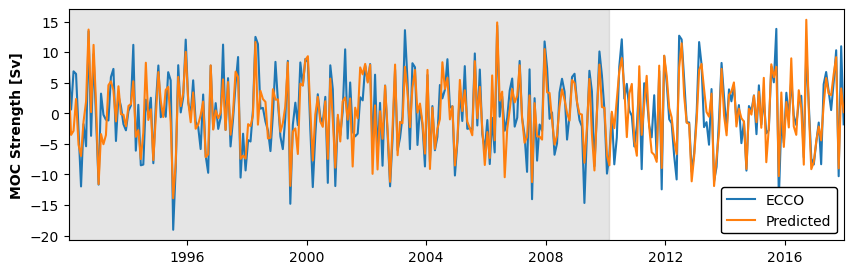

In [13]:
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))

plt_fp = f'/Users/emiliolr/Desktop/{filename}_timeseries.png'
plt.savefig(plt_fp, bbox_inches = 'tight')

plt.show()

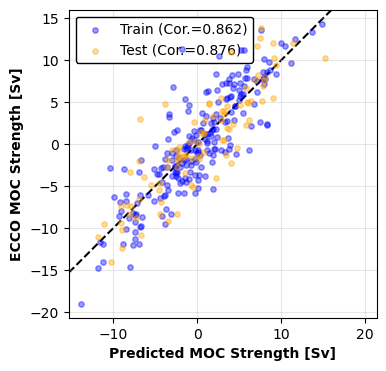

In [14]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)

plt_fp = f'/Users/emiliolr/Desktop/{filename}_scatterplot.png'
plt.savefig(plt_fp, bbox_inches = 'tight')

plt.show()